# Describe the mobility data

- Visualize activity counts
- Check outliers
- Visualize the spatial distribution of activities
- Visualize individual information


TBD

- Visualizing the mobility network.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime 
from dateutil import tz
import gzip
import time
import pickle
import copy

In [3]:
import sys
sys.path.append("../")

In [4]:
import utils

In [5]:
# read files
with open("../../data/02_intermediate/boston_stays.pickle", 'rb') as f:
    df = pickle.load(f)

# 2 - Boston 2016 sociodemographics of the CBGs
with open("../../data/03_processed/greater_boston_socioecon_2016.pickle", 'rb') as f:
    df_sociodemo = pickle.load(f)

# 3 - Boston shapefile
with open("../../data/03_processed/greater_boston_shp.pickle", 'rb') as f:
    df_shp = pickle.load(f)


In [45]:
# save path
save_path = '../../data/06_reporting/'

# Describe activity counts

In [6]:
# describe the activity distribution.
hour_of_day_count = df.groupby('hour_of_day').count().iloc[:, 0]
day_of_week_count = df.groupby('day_of_week').count().iloc[:, 0]

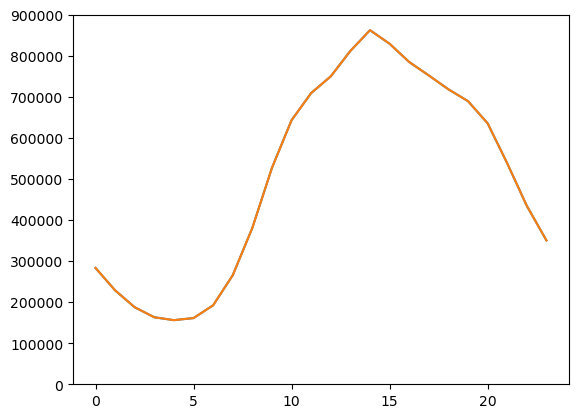

In [9]:
# hour of day and activities
plt.plot(hour_of_day_count)
plt.ylim(0, 900000)
plt.show()

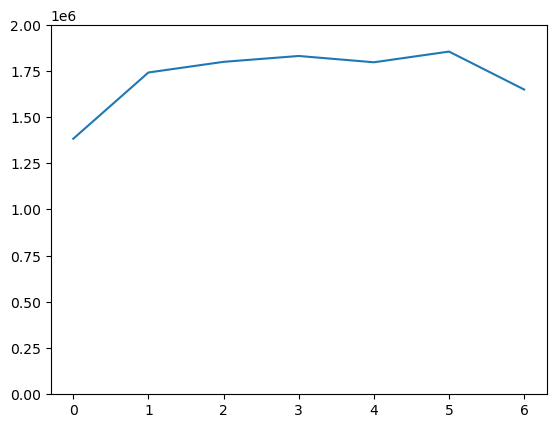

In [12]:
# day of week and activities - 0: Sunday; 6: Saturday
plt.plot(day_of_week_count)
plt.ylim(0, 2000000)
plt.show()

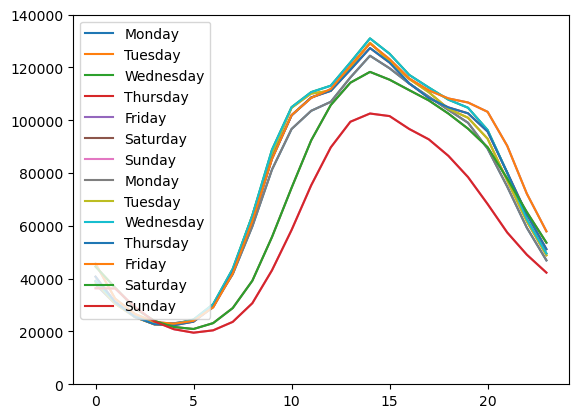

In [14]:
# distribution over seven days.
df_monday = df.loc[df['day_of_week'] == 1, :].groupby('hour_of_day').count().iloc[:, 0]
plt.plot(df_monday, label = 'Monday')

df_tuesday = df.loc[df['day_of_week'] == 2, :].groupby('hour_of_day').count().iloc[:, 0]
plt.plot(df_tuesday, label = 'Tuesday')

df_wednesday = df.loc[df['day_of_week'] == 3, :].groupby('hour_of_day').count().iloc[:, 0]
plt.plot(df_wednesday, label = 'Wednesday')

df_thursday = df.loc[df['day_of_week'] == 4, :].groupby('hour_of_day').count().iloc[:, 0]
plt.plot(df_thursday, label = 'Thursday')

df_friday = df.loc[df['day_of_week'] == 5, :].groupby('hour_of_day').count().iloc[:, 0]
plt.plot(df_friday, label = 'Friday')

df_saturday = df.loc[df['day_of_week'] == 6, :].groupby('hour_of_day').count().iloc[:, 0] 
plt.plot(df_saturday, label = 'Saturday')

df_sunday = df.loc[df['day_of_week'] == 0, :].groupby('hour_of_day').count().iloc[:, 0] 
plt.plot(df_sunday, label = 'Sunday')

plt.ylim(0, 140000)
plt.legend()
plt.show()

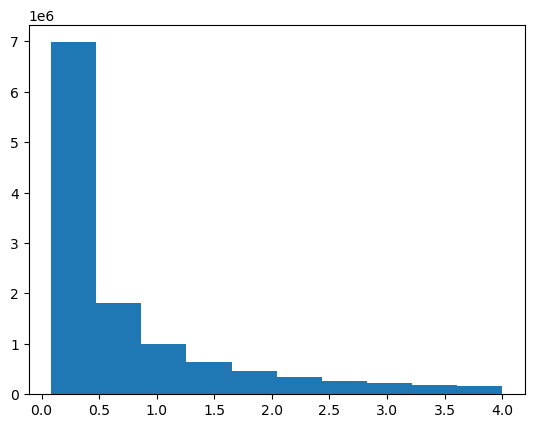

In [15]:
# duration of activities
plt.hist(df.duration/3600)
plt.show()

In [16]:
# Activity categories
activity_counts = np.unique(df.cat, return_counts = True)
print("Total number of activity categories", len(activity_counts[0]))

Total number of activity categories 633


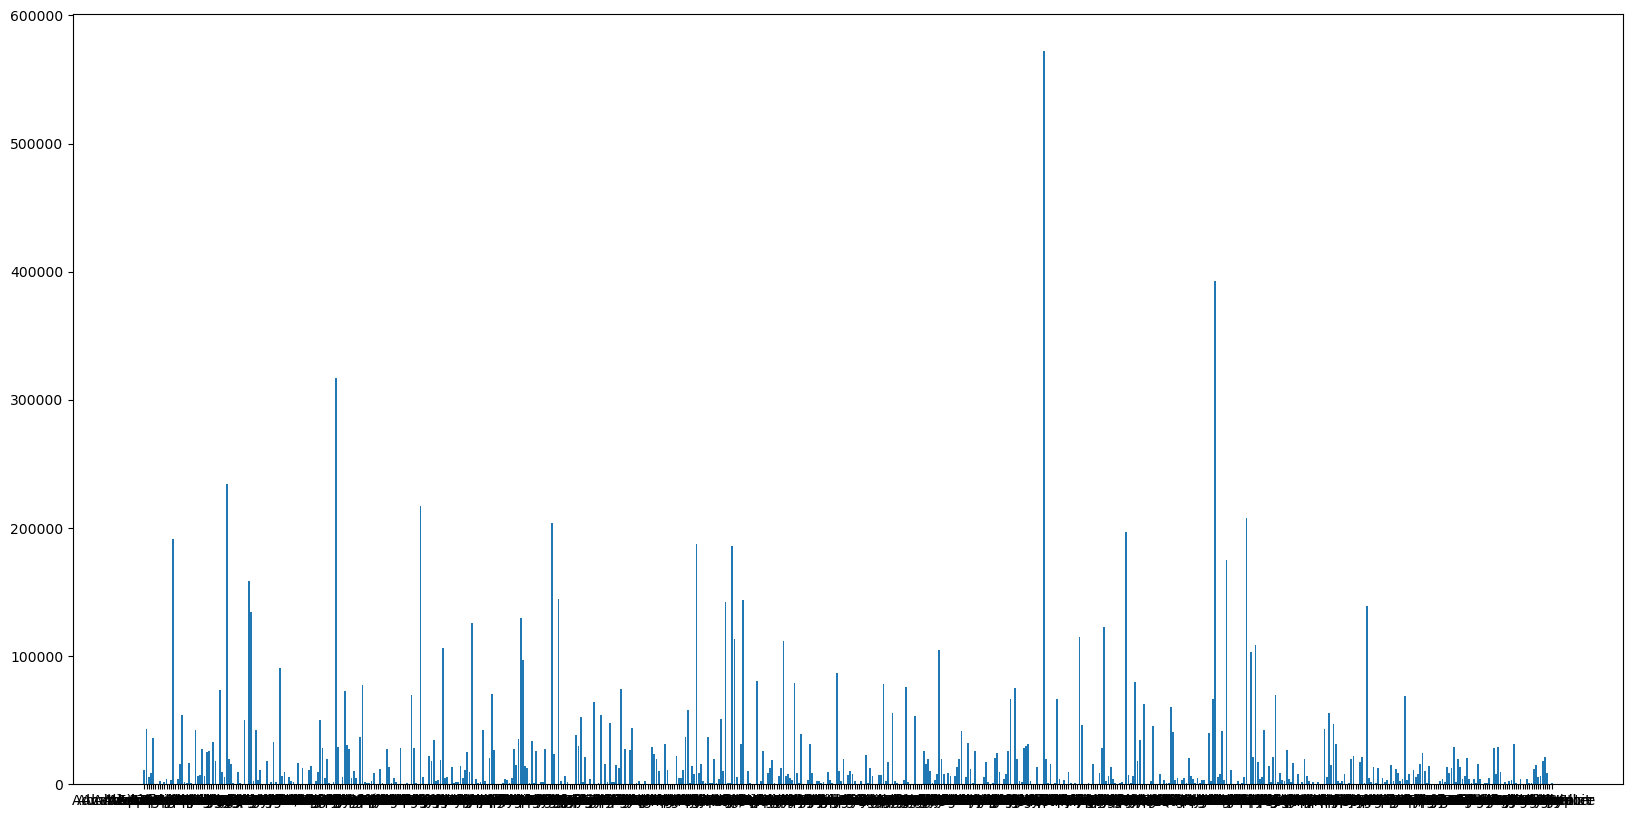

In [17]:
# Activity counts
plt.figure(figsize = (20, 10))
plt.bar(activity_counts[0], activity_counts[1])
plt.show()

In [18]:
# check activity frequencies
top_one_indx = np.argmax(activity_counts[1])
print("The most frequent activities: ", activity_counts[0][top_one_indx])

top_ten_index = np.argsort(activity_counts[1])[-10:]
print("Top ten frequent activities (low to high): ", activity_counts[0][top_ten_index])

# SW Q: What is the meaning of "American" from fsq? American restaurants, Building = residential, etc. Automotive is also gas station. 
# Doctor's Office: small clinical (not necessarily hospitals)

The most frequent activities:  Office
Top ten frequent activities (low to high):  ['Gas Station' 'American' 'Pizza' "Doctor's Office" 'Salon / Barbershop'
 'Church' 'Automotive' 'Building' 'Residential' 'Office']


In [19]:
# check activity frequency for different time points: 2, 8, 14, 20.
cat_2am = df.loc[df['hour_of_day'] == 2, :].groupby('cat').count().iloc[:, 0]
print("Most frequent behavior at 2am: ", cat_2am.index[np.argmax(cat_2am.values)])

cat_8am = df.loc[df['hour_of_day'] == 8, :].groupby('cat').count().iloc[:, 0]
print("Most frequent behavior at 8am: ", cat_8am.index[np.argmax(cat_8am.values)])

cat_12pm = df.loc[df['hour_of_day'] == 12, :].groupby('cat').count().iloc[:, 0]
print("Most frequent behavior at 12pm: ", cat_12pm.index[np.argmax(cat_12pm.values)])

cat_2pm = df.loc[df['hour_of_day'] == 14, :].groupby('cat').count().iloc[:, 0]
print("Most frequent behavior at 2pm: ", cat_2pm.index[np.argmax(cat_2pm.values)])

cat_8pm = df.loc[df['hour_of_day'] == 20, :].groupby('cat').count().iloc[:, 0]
print("Most frequent behavior at 8pm: ", cat_8pm.index[np.argmax(cat_8pm.values)])

# stay at home, but no POI - missing in the data set. 
# "residential": not necessarily at home, can be just close to friends' home.


Most frequent behavior at 2am:  Residential
Most frequent behavior at 8am:  Office
Most frequent behavior at 12pm:  Office
Most frequent behavior at 2pm:  Office
Most frequent behavior at 8pm:  Residential


In [20]:
# Check the spatial information.
# Visualize the spatial distribution of the data sets in MA and NH.
print("Number of unique GEOIDs are: ", len(np.unique(df.GEOID)))
print("Number of unique home GEOIDs are: ", len(np.unique(df.GEOID_home)))
print("Number of overlapping GEOIDs are: ", len(set(np.unique(df.GEOID)).intersection(set(np.unique(df.GEOID_home)))))
print("Number of joint GEOIDs are: ", len(set(np.unique(df.GEOID)).union(set(np.unique(df.GEOID_home)))))


Number of unique GEOIDs are:  3115
Number of unique home GEOIDs are:  3196
Number of overlapping GEOIDs are:  2907
Number of joint GEOIDs are:  3404


In [21]:
# Check the activity counts on the GEOIDs. 
activity_counts_geo = df.groupby('GEOID').count().iloc[:, 0]
activity_home_counts_geo = df.groupby('GEOID_home').count().iloc[:, 0]

# reset index. 
activity_counts_geo = activity_counts_geo.reset_index()
activity_home_counts_geo = activity_home_counts_geo.reset_index()


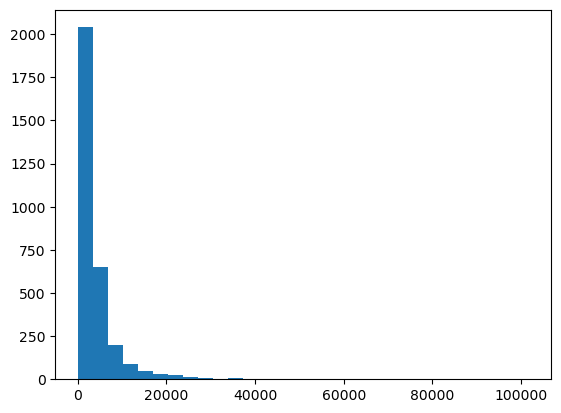

long tail distribution. The outlier is the Logan airport as an activity center.


In [22]:
# distribution of activity counts grouped by GEOIDs
plt.hist(activity_counts_geo['user'], bins = 30) # sw: long tail
plt.show()
print("long tail distribution. The outlier is the Logan airport as an activity center.")


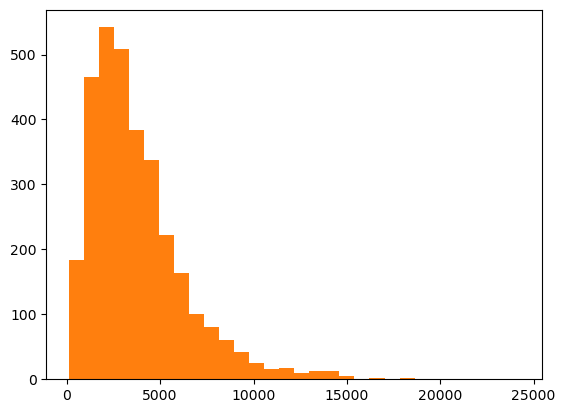

long tail distribution. The outlier is the Logan airport as a 'residential' place!!!


In [24]:
# distribution of activity counts grouped by GEOID_home
plt.hist(activity_home_counts_geo['user'], bins = 30) 
plt.show()
print("long tail distribution. The outlier is the Logan airport as a 'residential' place!!!")


# Visualize spatial info of activities

In [30]:
# aggregate to get the counts
activity_counts = df.groupby('GEOID').count().iloc[:, 0]
home_counts = df.groupby('GEOID_home').count().iloc[:, 0]

In [31]:
activity_counts

GEOID
250092011001    2817
250092021011    5888
250092021012     720
250092021013    2433
250092021021    3150
                ... 
330170870001    3177
330170870002    2293
330170870003    2690
330170870004    1321
330170880003     735
Name: user, Length: 3115, dtype: int64

In [29]:
df_shp

STATEFP COUNTYFP TRACTCE BLKGRPCE       NAMELSAD  MTFCC FUNCSTAT  \
GEOID                                                                           
250092011001      25      009  201100        1  Block Group 1  G5030        S   
250092011003      25      009  201100        3  Block Group 3  G5030        S   
250092011004      25      009  201100        4  Block Group 4  G5030        S   
250092021011      25      009  202101        1  Block Group 1  G5030        S   
250092021012      25      009  202101        2  Block Group 2  G5030        S   
...              ...      ...     ...      ...            ...    ...      ...   
330170880002      33      017  088000        2  Block Group 2  G5030        S   
330170880003      33      017  088000        3  Block Group 3  G5030        S   
330170885001      33      017  088500        1  Block Group 1  G5030        S   
330170885002      33      017  088500        2  Block Group 2  G5030        S   
330170885003      33      017  088500        3  Block Group 3  G5030        S   

                 ALAND   AWATER     INTPTLAT      INTPTLON  \
GEOID                                                        
250092011001    621459  1582718  +42.4440671  -070.9394124   
250092011003    597024   248882  +42.4188235  -070.9098103   
250092011004    851784   790689  +42.4243813  -070.9274763   
250092021011   1035587     7226  +42.4782666  -070.9002598   
250092021012    230034        0  +42.4715526  -070.9149131   
...                ...      ...          ...           ...   
330170880002  30708172  1160167  +43.4522291  -071.0146523   
330170880003  28836784   220871  +43.4167676  -071.0343527   
330170885001  46812600  1114629  +43.4830066  -071.0706405   
330170885002  61595411  5894030  +43.4988703  -071.1491430   
330170885003  45151738   889898  +43.4164901  -071.1404880   

                                                       geometry  
GEOID                                                            
250092011001  POLYGON ((-70.94328 42.43815, -70.94324 42.438...  
250092011003  POLYGON ((-70.93010 42.42650, -70.93008 42.426...  
250092011004  POLYGON ((-70.94106 42.42335, -70.93970 42.425...  
250092021011  POLYGON ((-70.91511 42.47505, -70.91486 42.475...  
250092021012  POLYGON ((-70.91808 42.46869, -70.91795 42.468...  
...                                                         ...  
330170880002  POLYGON ((-71.05501 43.45310, -71.05473 43.453...  
330170880003  POLYGON ((-71.08533 43.42436, -71.08351 43.426...  
330170885001  POLYGON ((-71.11150 43.50671, -71.11069 43.507...  
330170885002  POLYGON ((-71.19080 43.51503, -71.18794 43.517...  
330170885003  POLYGON ((-71.18388 43.47548, -71.18357 43.475...  

[3391 rows x 12 columns]

In [34]:
# augment the activity counts to df_shp
df_shp_w_activities = df_shp.merge(activity_counts, left_index=True, right_index=True, how = 'left') 
df_shp_w_activities = df_shp_w_activities.merge(home_counts, left_index=True, right_index=True, how = 'left') 

In [44]:
# rename the last two columns 'user_x' and 'user_y' as 'activity_counts' and 'home_counts'
df_shp_w_activities = df_shp_w_activities.rename(columns = {'user_x':'activity_counts',
                                                            'user_y':'home_counts'})

# replace nan by zeros
df_shp_w_activities.loc[df_shp_w_activities['activity_counts'].isna().values, 'activity_counts'] = 0.0
df_shp_w_activities.loc[df_shp_w_activities['home_counts'].isna().values, 'home_counts'] = 0.0

df_shp_w_activities


STATEFP COUNTYFP TRACTCE BLKGRPCE       NAMELSAD  MTFCC FUNCSTAT  \
GEOID                                                                           
250092011001      25      009  201100        1  Block Group 1  G5030        S   
250092011003      25      009  201100        3  Block Group 3  G5030        S   
250092011004      25      009  201100        4  Block Group 4  G5030        S   
250092021011      25      009  202101        1  Block Group 1  G5030        S   
250092021012      25      009  202101        2  Block Group 2  G5030        S   
...              ...      ...     ...      ...            ...    ...      ...   
330170880002      33      017  088000        2  Block Group 2  G5030        S   
330170880003      33      017  088000        3  Block Group 3  G5030        S   
330170885001      33      017  088500        1  Block Group 1  G5030        S   
330170885002      33      017  088500        2  Block Group 2  G5030        S   
330170885003      33      017  088500        3  Block Group 3  G5030        S   

                 ALAND   AWATER     INTPTLAT      INTPTLON  \
GEOID                                                        
250092011001    621459  1582718  +42.4440671  -070.9394124   
250092011003    597024   248882  +42.4188235  -070.9098103   
250092011004    851784   790689  +42.4243813  -070.9274763   
250092021011   1035587     7226  +42.4782666  -070.9002598   
250092021012    230034        0  +42.4715526  -070.9149131   
...                ...      ...          ...           ...   
330170880002  30708172  1160167  +43.4522291  -071.0146523   
330170880003  28836784   220871  +43.4167676  -071.0343527   
330170885001  46812600  1114629  +43.4830066  -071.0706405   
330170885002  61595411  5894030  +43.4988703  -071.1491430   
330170885003  45151738   889898  +43.4164901  -071.1404880   

                                                       geometry  \
GEOID                                                             
250092011001  POLYGON ((-70.94328 42.43815, -70.94324 42.438...   
250092011003  POLYGON ((-70.93010 42.42650, -70.93008 42.426...   
250092011004  POLYGON ((-70.94106 42.42335, -70.93970 42.425...   
250092021011  POLYGON ((-70.91511 42.47505, -70.91486 42.475...   
250092021012  POLYGON ((-70.91808 42.46869, -70.91795 42.468...   
...                                                         ...   
330170880002  POLYGON ((-71.05501 43.45310, -71.05473 43.453...   
330170880003  POLYGON ((-71.08533 43.42436, -71.08351 43.426...   
330170885001  POLYGON ((-71.11150 43.50671, -71.11069 43.507...   
330170885002  POLYGON ((-71.19080 43.51503, -71.18794 43.517...   
330170885003  POLYGON ((-71.18388 43.47548, -71.18357 43.475...   

              activity_counts  home_counts  
GEOID                                       
250092011001           2817.0       4188.0  
250092011003              0.0       1179.0  
250092011004              0.0       1383.0  
250092021011           5888.0       3156.0  
250092021012            720.0       1765.0  
...                       ...          ...  
330170880002              0.0       1968.0  
330170880003            735.0       6797.0  
330170885001              0.0       1223.0  
330170885002              0.0        372.0  
330170885003              0.0       2018.0  

[3391 rows x 14 columns]

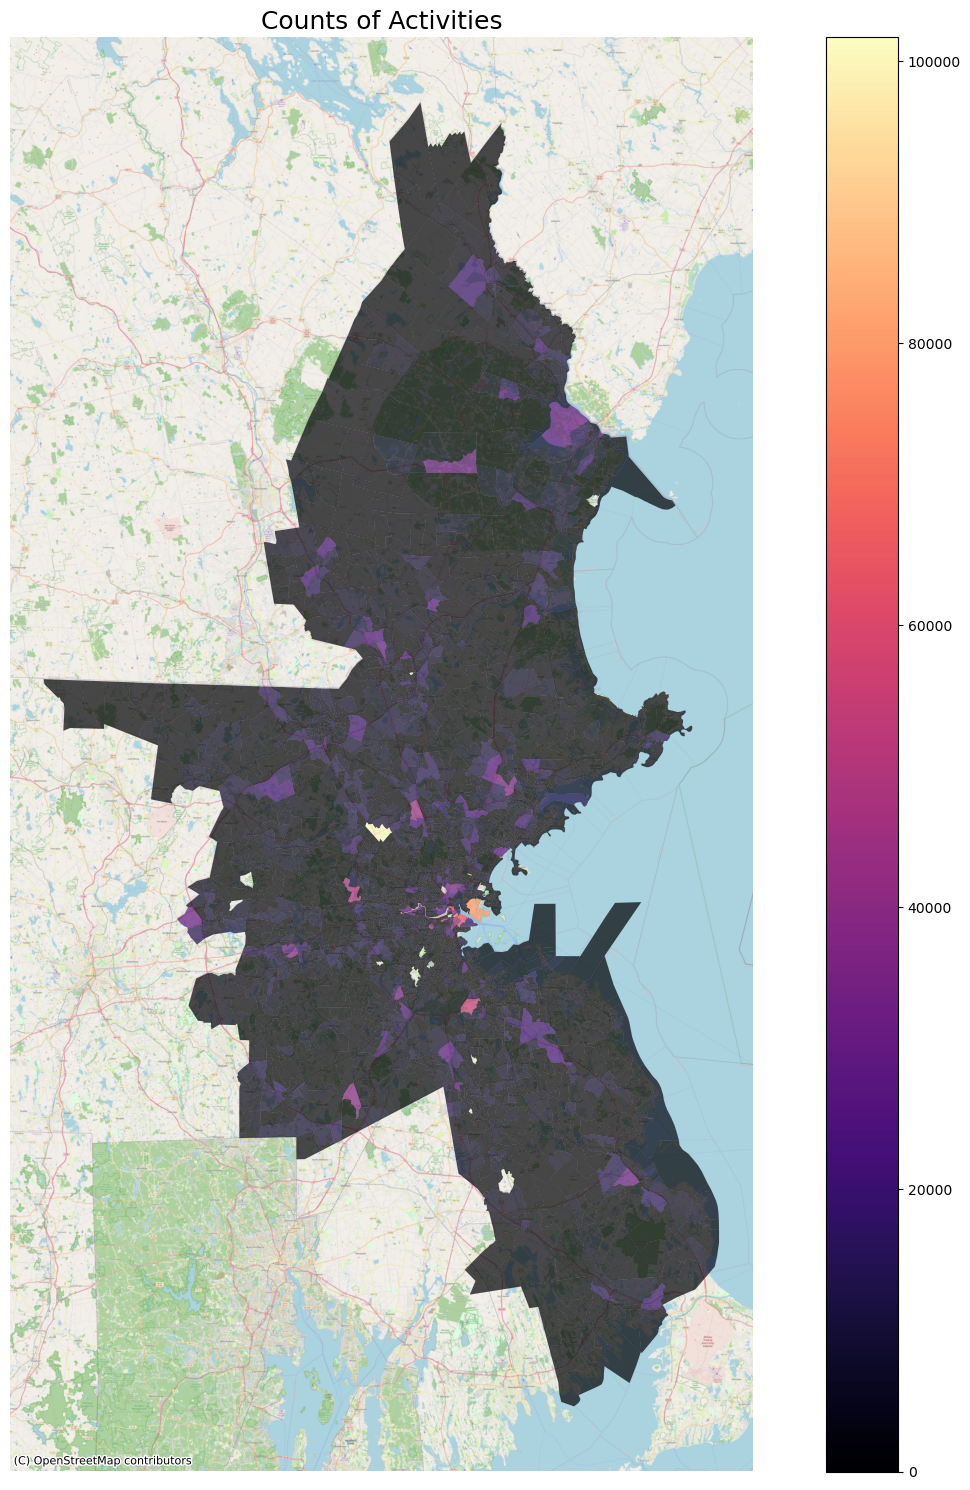

In [48]:
# visualize the activity counts
alpha = 0.7

utils.plot_node_with_base_map(df_shp_w_activities, 
                              'activity_counts', 
                              'Counts of Activities', 
                               alpha, 
                              'geo_activity_counts_greater_boston', 
                               save_path)

# Core-based statistical area - 
# https://en.wikipedia.org/wiki/Core-based_statistical_area
# https://www.census.gov/topics/housing/housing-patterns/about/core-based-statistical-areas.html


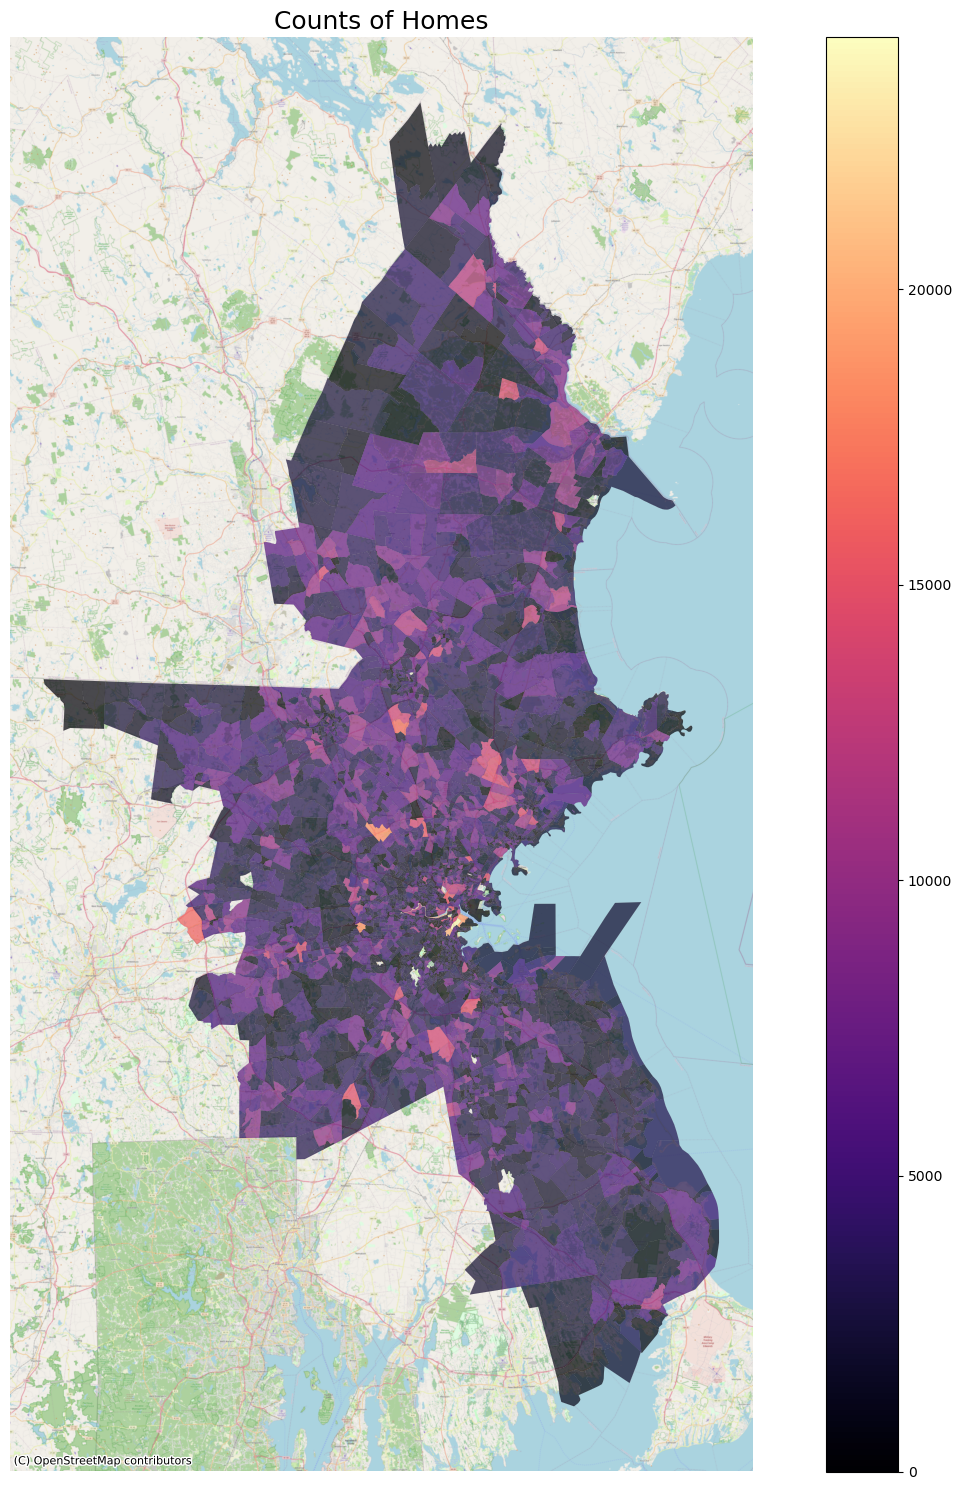

In [49]:
# visualize the home counts
alpha = 0.7

utils.plot_node_with_base_map(df_shp_w_activities, 
                              'home_counts', 
                              'Counts of Homes', 
                               alpha, 
                              'geo_home_counts_greater_boston', 
                               save_path) # only visual no save


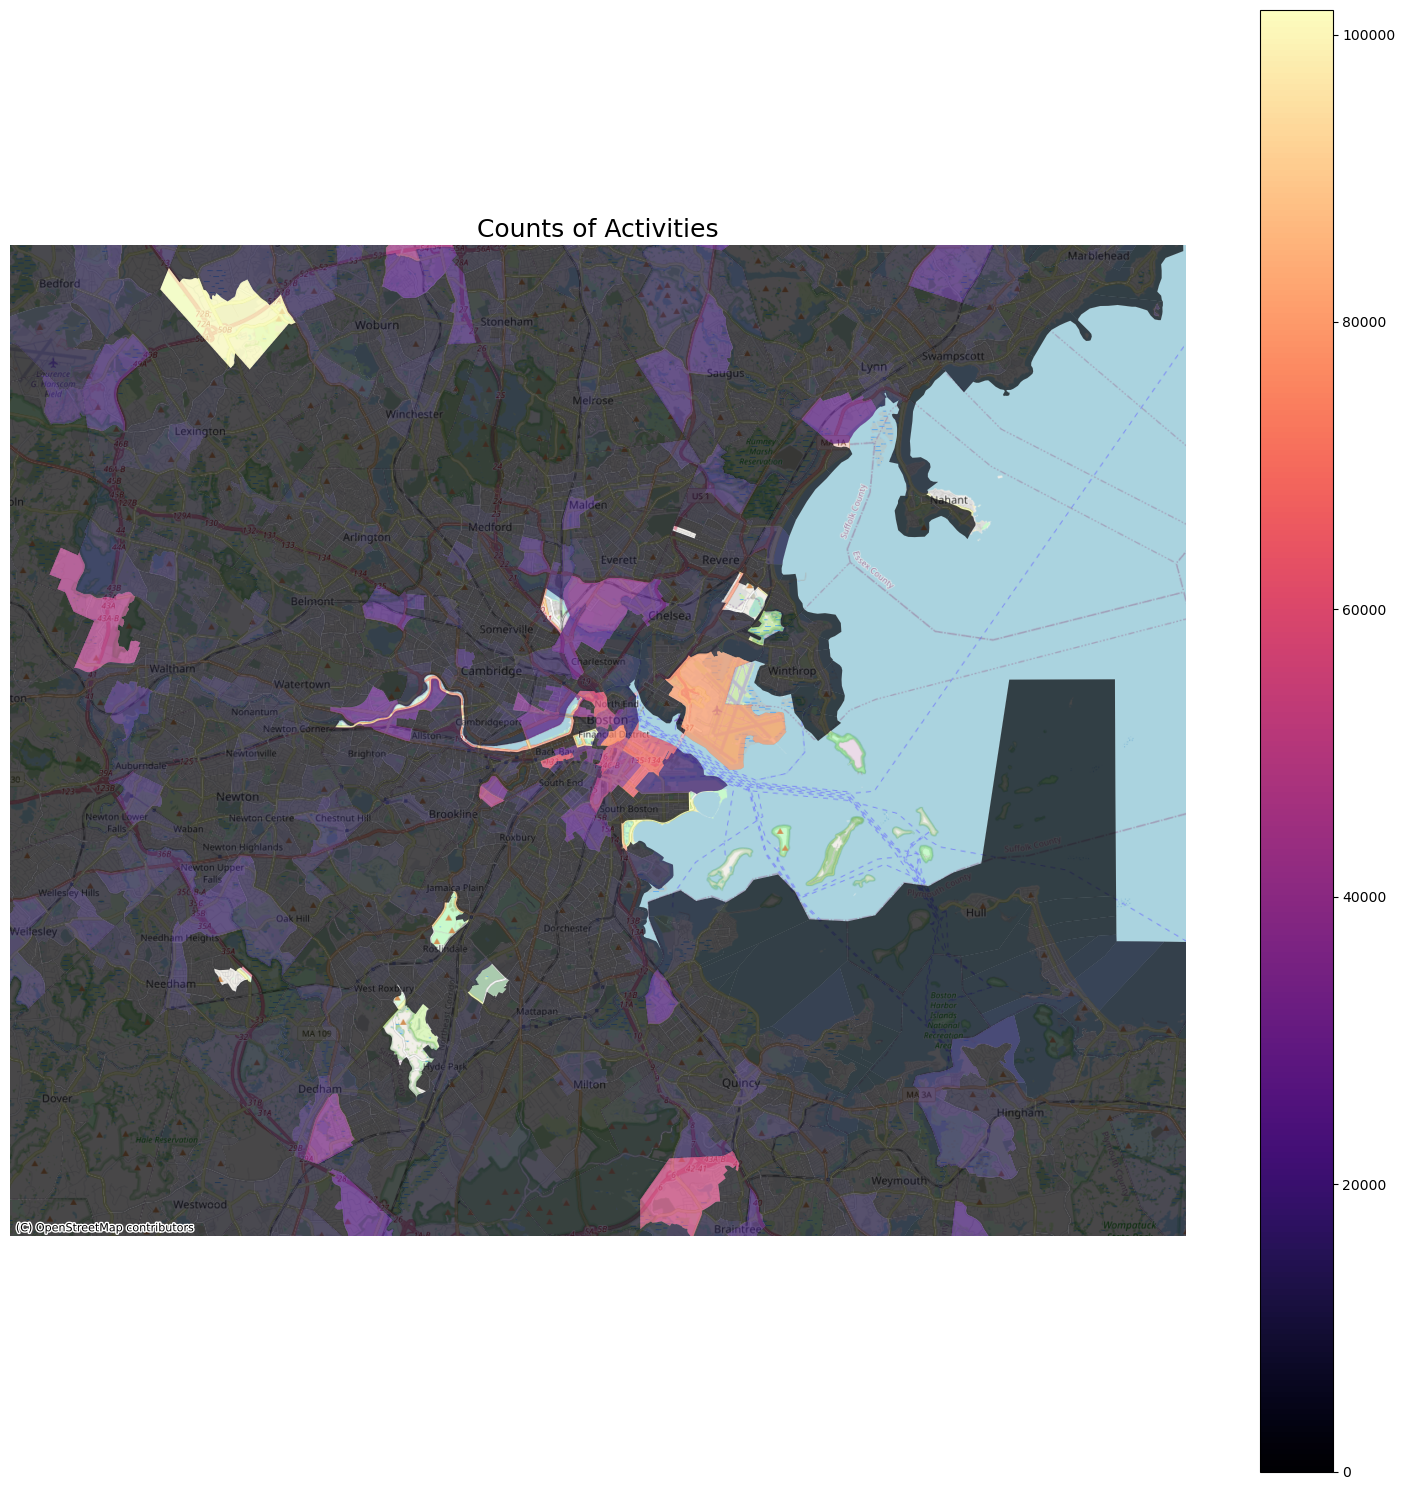

In [50]:
# visualize the activities around the Boston area.
from shapely.geometry import Point
point_left_up = Point(-71.302138, 42.503242) # lat & lon
point_right_down = Point(-70.822178, 42.204370) # lat & lon
box_4269 = gpd.GeoSeries([point_left_up, point_right_down], crs = 'epsg:4269')
box_3857 = box_4269.to_crs(epsg=3857)
xlim_3857 = (box_3857[0].x, box_3857[1].x)
ylim_3857 = (box_3857[1].y, box_3857[0].y)

utils.plot_node_with_base_map(df_shp_w_activities, 
                              'activity_counts', 
                              'Counts of Activities', 
                               alpha, 
                              'geo_activity_counts_boston', 
                               save_path, 
                               xlim_3857, ylim_3857)


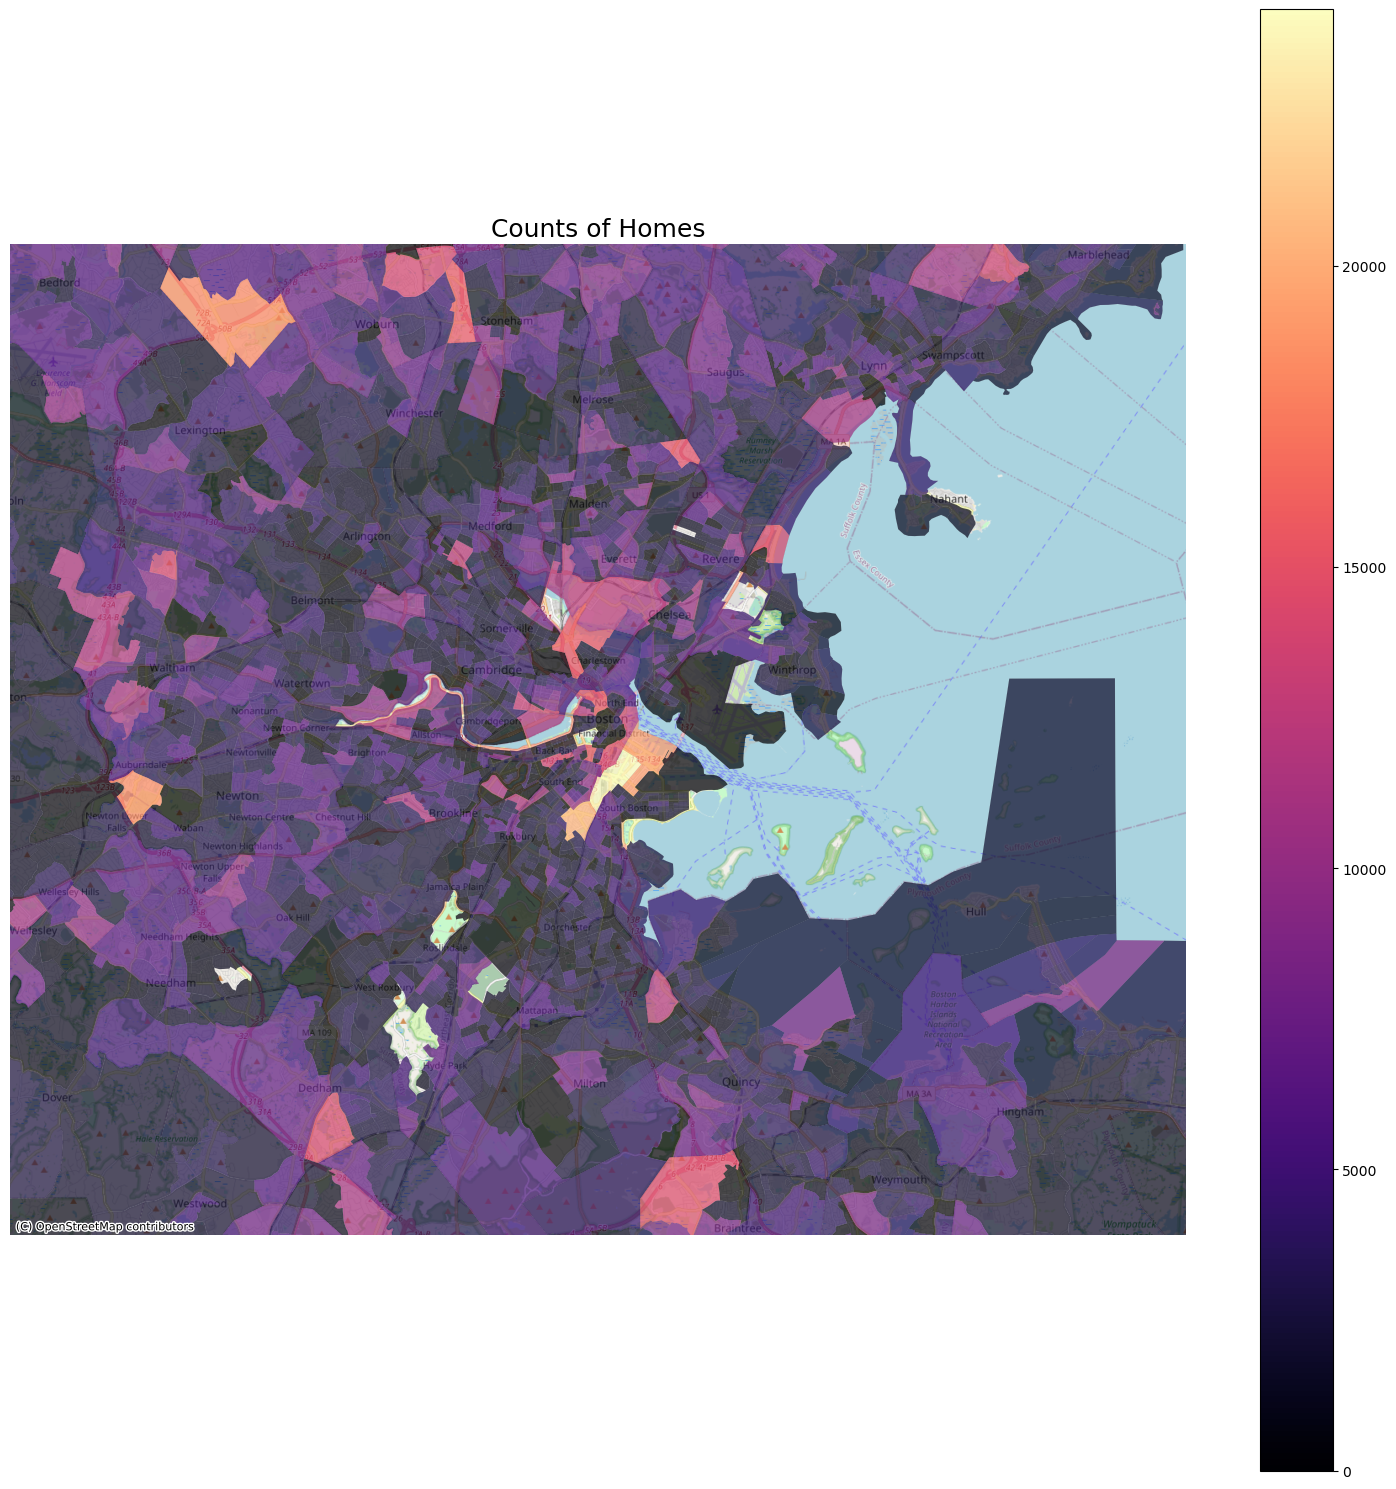

In [51]:
# visualize the home activities around the Boston area.
utils.plot_node_with_base_map(df_shp_w_activities, 
                              'home_counts', 
                              'Counts of Homes', 
                               alpha, 
                              'geo_home_counts_boston', 
                               save_path, 
                               xlim_3857, ylim_3857)


# Check two outliers

In [52]:
# Check outlier 1 - logan airport 
GEOID_Logan_Airport = '250259813002'

df_activity_logan = df.loc[df['GEOID'] == GEOID_Logan_Airport, :]
df_home_logan = df.loc[df['GEOID_home'] == GEOID_Logan_Airport, :]

#
print("Shenhao: Logan airport is the first outlier for both activity and residential activity counts.")
print("Shenhao: Note that only 139 users contribute to around 50,000 'home' activities...consider removing the 139 people.")

# 
print(df_activity_logan.shape)
print(df_home_logan.shape)

# 
print("Num of unique users: ", len(np.unique(df_activity_logan.user)))
print("Num of unique users (residential home?): ", len(np.unique(df_home_logan.user)))      

# 
logan_activities = np.unique(df_activity_logan.cat, return_counts = True)
logan_homes = np.unique(df_home_logan.cat, return_counts = True)

# return top five activities
print("Top five activities: ", logan_activities[0][np.argsort(logan_activities[1])[-5:]])
print("Top five activities (residential home?): ", logan_homes[0][np.argsort(logan_homes[1])[-5:]])


Shenhao: Logan airport is the first outlier for both activity and residential activity counts.
Shenhao: Note that only 139 users contribute to around 50,000 'home' activities...consider removing the 139 people.
(80092, 18)
(0, 18)
Num of unique users:  12869
Num of unique users (residential home?):  0
Top five activities:  ['Government' 'Tram' 'Plane' 'Terminal' 'Gate']
Top five activities (residential home?):  []


In [54]:
# check outlier 2.
GEOID_outlier = '250173324002'
df_activity_outlier = df.loc[df['GEOID'] == GEOID_outlier, :]

print("Shenhao: This outlier is an suburban activity center in Burlington consisting of AMC, Macy's, Lahey hospital & medical center")
print("Shenhao: You can see details of 42.481984, -71.213403 on Google map.")
print(df_activity_outlier.shape)
print("Num of unique users: ", len(np.unique(df_activity_outlier.user)))

# 
outlier_activities = np.unique(df_activity_outlier.cat, return_counts = True)

# 
print("Top five activities: ", outlier_activities[0][np.argsort(outlier_activities[1])[-5:]])


Shenhao: This outlier is an suburban activity center in Burlington consisting of AMC, Macy's, Lahey hospital & medical center
Shenhao: You can see details of 42.481984, -71.213403 on Google map.
(101706, 18)
Num of unique users:  11090
Top five activities:  ['Building' 'American' 'Supermarket' 'Hospital' 'Office']


# Visualize individual income

In [55]:
# choose only 9am subset
df_9am = df.loc[df.hour_of_day == 9, :]
df_9am = df_9am.loc[df_9am['GEOID_home'] != '250259813002', :]
df_9am = df_9am.reset_index(drop = True)
print(df_9am.shape)

(527028, 18)


In [56]:
# create spatial points for the individuals
from shapely.geometry import Point, LineString, Polygon

activity_point_list = []
for i in range(df_9am.shape[0]):
    point = Point(df_9am.loc[i, 'lon_medoid'], df_9am.loc[i, 'lat_medoid'])
    activity_point_list.append(point)
activity_point_shp = gpd.GeoSeries(activity_point_list)
    
    
home_point_list = []    
for i in range(df_9am.shape[0]):
    point = Point(df_9am.loc[i, 'home_lon_med'], df_9am.loc[i, 'home_lat_med'])
    home_point_list.append(point)
home_point_shp = gpd.GeoSeries(home_point_list)


In [57]:
# create two geo shapefiles to visualize the income
# 
df_activity_shp = copy.copy(df_9am)
df_activity_shp['geometry'] = activity_point_shp
df_activity_shp = gpd.GeoDataFrame(df_activity_shp, crs = 'epsg:4269')

# 
df_home_shp = copy.copy(df_9am)
df_home_shp['geometry'] = home_point_shp
df_home_shp = gpd.GeoDataFrame(df_home_shp, crs = 'epsg:4269')


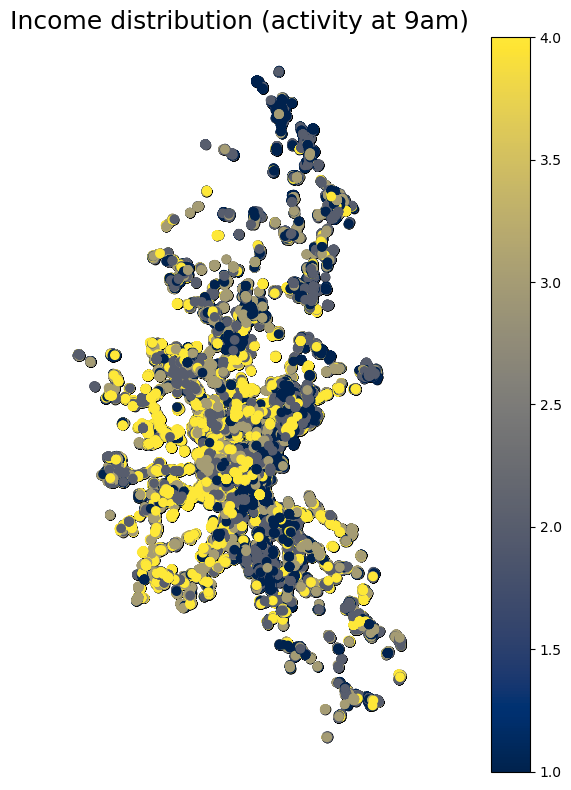

In [59]:
# visualize the income distribution for the activities at 9am
utils.plot_node_attributes(df_activity_shp, 
                           'quant', 
                           'Income distribution (activity at 9am)', 
                           '_', 
                           '_')

# highly concentrated when we check people's activities


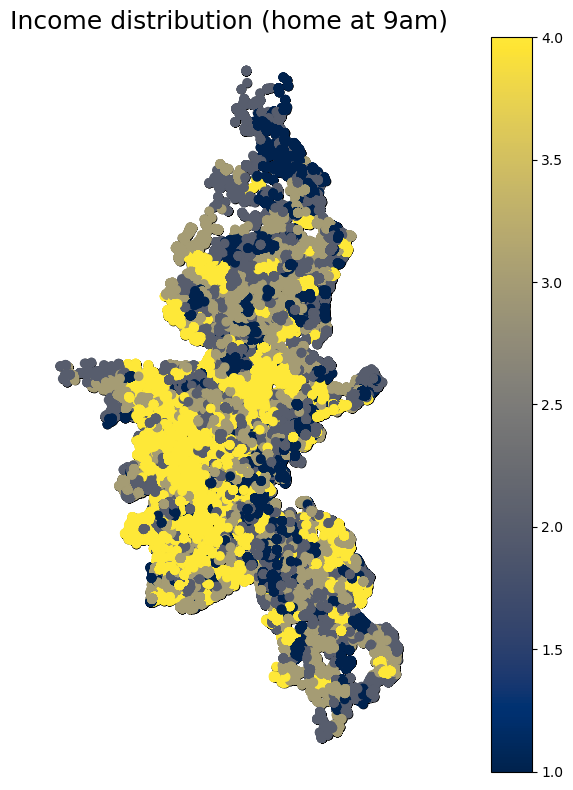

In [60]:
# visualize the income distribution for people (home) at 9am
utils.plot_node_attributes(df_home_shp, 
                           'quant', 
                           'Income distribution (home at 9am)', 
                           '_', 
                           '_')

# highly scattered when we check people's home locations.
# indicator that activities represent more mixture than home locations. 
